In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

# # Install epicaller if you haven’t
# pip install epicaller==1.1.11

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/NAD02_IST01_Infinity_01_MRD_MBs3Lung_call_replacement_MRD_0613024"

# Data preocessing

In [3]:
#Readin samples from MRD all col csv file of this batch
df_NAD_MRD_all = pd.read_csv(f"{work_dir}/20230918_NAD02_IST01_Infinity_01_pre_tb_tb_changed_all_cols_MRD.csv", header = 0) 

print("Total sample size of NAD02_IST01_Infinity_01 batch is " + str(df_NAD_MRD_all.shape[0]) + "\n") 
print("Total unique sample size of NAD02_IST01_Infinity_01 batch is " + str(df_NAD_MRD_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of NAD02_IST01_Infinity_01 batch is " + str(df_NAD_MRD_all.Patient_ID.nunique()) + "\n")

df_NAD_MRD_all.head()

Total sample size of NAD02_IST01_Infinity_01 batch is 11

Total unique sample size of NAD02_IST01_Infinity_01 batch is 10

Total unique patient sample size of NAD02_IST01_Infinity_01 batch is 10



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected
0,NADIM II,01700002_20191015,A0844477,B00487952,1700002,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,23.972,3.0,0,08/03/2023,10/15/2019,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00487952,LUNG,0.809008,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected
1,NADIM II,00800014_20200109,A0844476,B00487951,800014,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,16.952,3.0,0,08/03/2023,01/09/2020,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Squamous,Squamous,LUNG,Squamous,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00487951,LUNG,1.727832,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected
2,NADIM II,00400086_20210504,A0844472,B00487958,400086,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,28.704,3.0,0,08/03/2023,05/04/2021,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Squamous,Squamous,LUNG,Squamous,LUNG,B00487958,0.000965,TP53,M237I,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577570.0,7.0,M237I,C>T,c.711G>A,NM_000546.6,0.000965,NaN,COSV52661887,rs587782664,3854.0,B00487958,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",B00487958,LUNG,3.917681,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.096525,No,Not Detected,Not Detected
3,NADIM II,03600012_20191218,A0844479,B00487948,3600012,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,22.152,3.0,0,08/03/2023,12/18/2019,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0304_AHF2NNDSX7_PS3C143_AP2.Sirius-1.1.1-RLS,230914_A01552_0304_AHF2NNDSX7,NOS/Undifferentiated,NOS/Undifferentiated,LUNG,NOS/Undifferentiated,LUNG,NaN,0.000000,NaN,

# Generate MB S3 Lung caller outputs for NAD02_IST01_Infinity_01 batch

In [4]:
#The input files (region_file, lr_model_file, control_region_file and mr_model_file were got from Shile (Elmira) check slack conversation
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_s3_lung_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/msre_regions.tsv'
    control_region_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/v5_model_control_regions.tsv'
    lr_model_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_Lung_log"
    output_dir = f"{workdir}/MB_Lung_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        # mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [5]:
df_NAD_MRD_1 = df_NAD_MRD_all.copy()

In [6]:
df_NAD_MRD_2 = df_NAD_MRD_all.copy()

#run the function to generate all the MB S3 Lung caller ouputs for NAD02_IST01_Infinity_01 batch 
run_mb_s3_lung_caller_wrapper_slurm(df_NAD_MRD_all, 
                      "/ghds/projects/pharma/projects/sirius_pharma/mrd_ist/smc_lung_s3_MB/CANDIDATE_S3_Lung_-_V4.model_file.98_spec_set_on_s3_data.tsv", 
                      f"{work_dir}")

Submitted batch job 79823548
Submitted batch job 79823549
Submitted batch job 79823551
Submitted batch job 79823552
Submitted batch job 79823554
Submitted batch job 79823556
Submitted batch job 79823558
Submitted batch job 79823559
Submitted batch job 79823561
Submitted batch job 79823562
Submitted batch job 79823563


# Retrieve MB S3 Lung score and Binary results

In [7]:
#Generate MB Lung score for NAD02_IST01_Infinity_02 batch
df_NAD_MRD_2 = df_NAD_MRD_1.copy()

df_NAD_MRD_2["MB_Lung_call"] = np.nan
df_NAD_MRD_2["MB_Lung_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_Lung_output"
for index, crc_row in df_NAD_MRD_2.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv" 
    msre_df = pd.read_table(msre_mr_file)
    # print(msre_df.head())

    df_NAD_MRD_2.at[index, "MB_Lung_score"] = msre_df.loc[0, "methyl_score"]
    df_NAD_MRD_2.at[index, "MB_Lung_call"] = "Detected" if msre_df.loc[0, "methyl_call"] == 1 else "Not Detected"

df_NAD_MRD_2.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Lung_call,MB_Lung_score
0,NADIM II,01700002_20191015,A0844477,B00487952,1700002,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,23.972,3.0,0,08/03/2023,10/15/2019,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00487952,LUNG,0.809008,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-22.765619
1,NADIM II,00800014_20200109,A0844476,B00487951,800014,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,16.952,3.0,0,08/03/2023,01/09/2020,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Squamous,Squamous,LUNG,Squamous,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00487951,LUNG,1.727832,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-22.719329
2,NADIM II,00400086_20210504,A0844472,B00487958,400086,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,28.704,3.0,0,08/03/2023,05/04/2021,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Squamous,Squamous,LUNG,Squamous,LUNG,B00487958,0.000965,TP53,M237I,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577570.0,7.0,M237I,C>T,c.711G>A,NM_000546.6,0.000965,NaN,COSV52661887,rs587782664,3854.0,B00487958,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",B00487958,LUNG,3.917681,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.096525,No,Not Detected,Not Detected,Not Detected,-21.922977
3,NADIM II,03600012_20191218,A0844479,B00487948,3600012,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,22.152,3.0,0,08/03/2023,12/18/2019,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0304_AHF2NNDSX7_PS3C143_AP2.Sirius-1.1.1-RLS,230914_A01552_0304_AH

# Generate the epiTFv2 beta score results

In [8]:
#set up python interpreter based
# This is for epiTFv2beta
%env PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
%env SCRIPT_DIR=/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
%env SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
%env BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py

env: PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
env: SCRIPT_DIR=/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
env: SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
env: BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py


In [9]:
!echo $PYTHON
!echo $SCRIPT_DIR
!echo $SAMPLE_CMD
!echo $BATCH_CMD

/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
$SCRIPT_DIR/run_epiTF.py
$SCRIPT_DIR/run_epiTF_batch.py


In [ ]:
# #generate epiTF output by TFv2beta method local version
# df_FIS_MRD_3 = df_FIS_MRD_2.copy()

# tfv2_output_dir = f"{work_dir}/TFv2beta_output"


# PYTHON = '/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python'
# SCRIPT_DIR = '/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts/'

# # Check if the output directory exists, if not, create it
# if not os.path.exists(tfv2_output_dir):
#     os.makedirs(tfv2_output_dir)

# for index, row in df_FIS_MRD_3.iterrows():
#     #This is to deal the the cluster migration issue
#     fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
#     sample_id = row["GHSampleID"]
#     sample_path = f"{fc_dir}/{sample_id}"
#     mbd_path = f"{sample_path}/{sample_id}.mbd_hyper_molecules.tsv"

#     try:
#         # Run the script for each sample
#         command = f"{PYTHON} {SCRIPT_DIR}run_epiTF.py {mbd_path} {sample_path} {tfv2_output_dir} {sample_id}"
#         os.system(command)
#     except FileNotFoundError:
#         print(f"No file found for {sample_id}")
#     except Exception as e:
#         print(f"An error occurred with {sample_id}: {str(e)}")


In [11]:
# Generate epiTF output by TFv2beta method slurm version

# Step 1: save the input csv file
df_NAD_MRD_3 = df_NAD_MRD_2.copy()
df_NAD_MRD_3.to_csv(f"{work_dir}/df_NAD_MRD_3.csv", index=False)

# Step 2: edit the slurm script
# Step 2.1: define the out_path path; define the column # in the script for extracting "fc_dir" and "sample_id"; this is optional: | sed 's/\/ghess\//\/ghsfa\/projects\//'

# STEP 3: run the slurm script
os.system(f"sbatch {work_dir}/run_TFv2beta_pancanTF_accuracy.sh")

Submitted batch job 79825503


0

In [12]:
# This is beta version
#retrieve the epiTF ("epiTFnewfit3_pan") from TFv2beta
df_NAD_MRD_3 = pd.read_csv(f"{work_dir}/df_NAD_MRD_3.csv", header = 0)
df_NAD_MRD_4 = df_NAD_MRD_3.copy()

df_NAD_MRD_4['pred_frac_force'] = None 

out_path = f"{work_dir}/TFv2beta_output"

for index, row in df_NAD_MRD_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{out_path}/{sample_id}.epiTF_model_predictions.csv"
    
    try:
        df_temp = pd.read_csv(file_path, index_col=0)
        value_beta = df_temp.squeeze()['epiTFnewfit3_pan']
        df_NAD_MRD_4.at[index, 'pred_frac_force'] = value_beta
        
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")

df_NAD_MRD_5 = df_NAD_MRD_4.copy()
df_NAD_MRD_5.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Lung_call,MB_Lung_score,pred_frac_force
0,NADIM II,01700002_20191015,A0844477,B00487952,1700002,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,23.972,3.0,0,08/03/2023,10/15/2019,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00487952,LUNG,0.809008,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-22.765619,0.00026
1,NADIM II,00800014_20200109,A0844476,B00487951,800014,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,16.952,3.0,0,08/03/2023,01/09/2020,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Squamous,Squamous,LUNG,Squamous,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00487951,LUNG,1.727832,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-22.719329,0.000316
2,NADIM II,00400086_20210504,A0844472,B00487958,400086,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,28.704,3.0,0,08/03/2023,05/04/2021,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0303_BHF2CVDSX7_PS3C143_AP3.Sirius-1.1.1-RLS,230914_A01552_0303_BHF2CVDSX7,Squamous,Squamous,LUNG,Squamous,LUNG,B00487958,0.000965,TP53,M237I,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577570.0,7.0,M237I,C>T,c.711G>A,NM_000546.6,0.000965,NaN,COSV52661887,rs587782664,3854.0,B00487958,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",B00487958,LUNG,3.917681,5.73,0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.096525,No,Not Detected,Not Detected,Not Detected,-21.922977,0.000071
3,NADIM II,03600012_20191218,A0844479,B00487948,3600012,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.000000,22.152,3.0,0,08/03/2023,12/18/2019,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230914_A01552_0304_AHF2NNDSX7_PS3C143_

# Generate the MRD report of NAD02_IST01_Infinity_01 batch with MB S3 Lung caller and epiTFv2 result

In [14]:
#readin the MRD report (final deliverable version) of NAD02_IST01_Infinity_01 batch
df_NAD_MRD_simple = pd.read_csv(f"{work_dir}/20230918_NAD02_IST01_Infinity_01_pre_tb_tb_changed_RUO_report_MRD.csv", header = 0) 

# Get the list of columns present in both df_NAD_MRD_5 and df_NAD_MRD_simple
common_columns = df_NAD_MRD_5.columns.intersection(df_NAD_MRD_simple.columns)

# Ensure that MB_Lung_call and MB_Lung_score are included in the final DataFrame
additional_columns = ["MB_Lung_call", "MB_Lung_score", "pred_frac_force"]
final_columns = common_columns.tolist() + [col for col in additional_columns if col in df_NAD_MRD_5.columns]

# Create a df with all the columns
df_NAD_MRD_final_full = df_NAD_MRD_5[final_columns]

#save the output for later report generation purpose
# Important NOTE: based on the .shape output, the left join result might not be expected that's because of the exsit of duplicate GHSampleID. The df_NAD_MRD_final serves as an intermediate/input file for the later two functions "generate_updated_MRD_report" and "generate_updated_MRD_report_final". So it's okay to leave it like this. 
print(df_NAD_MRD_simple.shape)
print(df_NAD_MRD_final_full.shape)
df_NAD_MRD_final = pd.merge(df_NAD_MRD_simple, df_NAD_MRD_final_full[['GHSampleID', 'MB_Lung_call', 'pred_frac_force']], on="GHSampleID", how='left')
print(df_NAD_MRD_final.shape)
df_NAD_MRD_final.head()

(11, 35)
(11, 38)
(13, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_call,pred_frac_force
0,NADIM II,01700002_20191015,A0844477,B00487952,1700002,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.972,3.0,0,08/03/2023,10/15/2019,09/19/2023,Not Detected,0.00026
1,NADIM II,00800014_20200109,A0844476,B00487951,800014,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.952,3.0,0,08/03/2023,01/09/2020,09/19/2023,Not Detected,0.000316
2,NADIM II,00400086_20210504,A0844472,B00487958,400086,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.704,3.0,0,08/03/2023,05/04/2021,09/19/2023,Not Detected,0.000071
3,NADIM II,03600012_20191218,A0844479,B00487948,3600012,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.152,3.0,0,08/03/2023,12/18/2019,09/19/2023,Not Detected,0.000113
4,NADIM II,00100081_20210114,A0844471,B00487956,100081,Adenocarcinoma,IIIB,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Detected,Detected,0.000928,Yes,SNV,NaN,TP53,17.0,7578449.0,5.0,A161S,C>A,c.481G>T,NM_000546.6,0.451389,NaN,COSV52789715,NaN,3028.0,18.512,3.0,0,08/03/2023,01/14/2021,09/19/2023,Detected,0.00036


In [15]:
def generate_updated_MRD_report(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF):
    """
    Generate an updated MRD report incorporating MB caller and epiTF results.
    
    This function processes an initial deliverable MRD DataFrame by incorporating updates based on the MB caller results and forced epiTF predictions. 
    It addresses inconsistencies between ctDNA detection and MB calls, updates reportable somatic variants based on all_col_MRD.csv file, and handles failed samples (i.e. NaN samples in "ctDNA_detected" column). 

    Parameters:
    - deliverable_MRD (pd.DataFrame): The originial MRD file DataFrame (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv) with additional two columns of MB binary caller result and epiTF score.
    - original_all_col_MRD (pd.DataFrame): The comprehensive MRD DataFrame containing all columns, including reportable somatic variants (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv).
    - binary_caller_result_column (str): The column name in the deliverable DataFrame that contains the MB caller results (e.g. "MB_Lung_v4_call"). 
    - forced_epiTF (str): The column name in the deliverable DataFrame for the forced epiTF predictions.

    Returns:
    pd.DataFrame: The updated MRD DataFrame after processing.

    The function performs several key steps:
    - Identifies and addresses inconsistencies between ctDNA detection and MB caller results.
    - Updates the reportable somatic variants for identified samples.
    - Handles samples with NaN "ctDNA_detected" values by setting relevant columns to NaN.
    """

    updated_MRD = deliverable_MRD.copy()

    # List of original columns in deliverable MRD report for later subseting from the updated_MRD to genearate the final output
    columns_to_keep = updated_MRD.columns.intersection(original_all_col_MRD.columns)

    # Part 1: Addressing flipped calls where "ctDNA_detected" is Not Detected but binary_caller_result_column is Detected
    inconsistent_ids_detected_not = updated_MRD.loc[
        (updated_MRD['ctDNA_detected'] == 'Not Detected') & 
        (updated_MRD[binary_caller_result_column] == 'Detected'), 
        'GHSampleID'
    ].unique()

    # Identify the GHSampleIDs that need to make updates in the new deliverable report. They should be:
        ## 1."ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
        ## 2. No reportable somatic variants in the original report (i.e "Somatic_variant_reportable" is "No")
        ## 3. There are reportable somatic variants in the all_col_MRD.csv report for these samples (i.e "tvf_call" is 1)
    ids_with_variants_yes = original_all_col_MRD[original_all_col_MRD['tvf_call'] == 1]['GHSampleID'].unique()
    ids_to_update = [id_ for id_ in inconsistent_ids_detected_not if id_ in ids_with_variants_yes]

    # Removing original "Somatic_variant_reportable" is "No" rows for these specific GHSampleIDs from df_BMS_MRD_update before incoporting the reportable somatic variant calls from all_col_MRD.csv report
    updated_MRD = updated_MRD.loc[~((updated_MRD['GHSampleID'].isin(ids_to_update)) & 
                                    (updated_MRD['Somatic_variant_reportable'] == 'No'))]
    
    # Append any reportable somatic variant calls from all_col_MRD.csv report (i.e "tvf_call" is 1) from original_all_col_MRD for these ids
    for ghsampleid in ids_to_update:
        relevant_variants = original_all_col_MRD[(original_all_col_MRD['GHSampleID'] == ghsampleid) & 
                                                 (original_all_col_MRD['tvf_call'] == 1)][columns_to_keep]
        
        # Fetch the MB_Lung_v4_call and pred_frac_force values from the original deliverable_MRD for the current GHSampleID
        mb_call_value = deliverable_MRD.loc[deliverable_MRD['GHSampleID'] == ghsampleid, binary_caller_result_column].values[0]
        epiTF_value = deliverable_MRD.loc[deliverable_MRD['GHSampleID'] == ghsampleid, forced_epiTF].values[0]

        for _, variant_row in relevant_variants.iterrows():
            # Check if the variant already exists in updated_MRD
            if not updated_MRD[(updated_MRD['GHSampleID'] == variant_row['GHSampleID']) & 
                               (updated_MRD['Gene'] == variant_row['Gene'])].empty:

                continue  # Skip if this variant exists
            # Append the variant to updated_MRD
            #need to add one more step which is to change the "Somatic_variant_reportable" to "Yes" for the new added variants
            variant_row['Somatic_variant_reportable'] = 'Yes'
            # Update MB_Lung_v4_call and pred_frac_force for the new variant
            variant_row[binary_caller_result_column] = mb_call_value
            variant_row[forced_epiTF] = epiTF_value
            updated_MRD = pd.concat([updated_MRD, pd.DataFrame([variant_row])], ignore_index=True)
    
    # Part 2: Addressing flipped calls where ctDNA_detected is Detected and binary_caller_result_column is Not Detected
    # Identify samples where "ctDNA_detected" is "Detected" and "MB_Lung_v4_call" is "Not Detected"
    flipped_ids_ctDNA_detected = updated_MRD[
        (updated_MRD['ctDNA_detected'] == 'Detected') & 
        (updated_MRD[binary_caller_result_column] == 'Not Detected')
    ]['GHSampleID'].unique()

    # Define columns to change (replace with NaN) in the flipped call scenario where "ctDNA_detected" is Detected but "MB_Lung_v4_call" is Not Detected
    columns_to_nullify = [
        'Variant_type', 'Indel_type', 'Gene', 'Chromosome', 'Position', 'Exon', 
        'Mut_aa', 'Mut_nt', 'Mut_cdna', 'Transcript', 'Percentage', 'Splice_effect', 
        'COSMIC', 'dbSNP', 'Mol_count'
    ]

    # Only need to consider the case where GHSampleIDs with "Somatic_variant_reportable" as "Yes" for specific action
    for sample_id in flipped_ids_ctDNA_detected:
        # Filter for rows with this sample ID where "Somatic_variant_reportable" is "Yes"
        rows_to_modify = updated_MRD[
            (updated_MRD['GHSampleID'] == sample_id) & 
            (updated_MRD['Somatic_variant_reportable'] == 'Yes')
        ].index
        
        if rows_to_modify.size > 0:
            # If there are rows to modify, proceed to nullify columns and set "Somatic_variant_reportable" to "No"
            # Select the first row to modify
            first_row_index = rows_to_modify[0]
            updated_MRD.loc[first_row_index, 'Somatic_variant_reportable'] = 'No'
            updated_MRD.loc[first_row_index, columns_to_nullify] = np.nan
            
            # If more than one row exists, remove the extra rows
            if len(rows_to_modify) > 1:
                updated_MRD.drop(index=rows_to_modify[1:], inplace=True)

    # Part 3: Handling NaN "ctDNA_detected" values
    nan_ctDNA_idxs = updated_MRD[updated_MRD['ctDNA_detected'].isna()].index
    updated_MRD.loc[nan_ctDNA_idxs, binary_caller_result_column] = np.nan
    updated_MRD.loc[nan_ctDNA_idxs, forced_epiTF] = np.nan

    # Final duplication check and DataFrame shape verification
    updated_MRD.drop_duplicates(inplace=True)

    # Retain only original columns in the final DataFrame
    updated_MRD = updated_MRD[deliverable_MRD.columns]

    return updated_MRD



In [16]:
#generate the report outputs
binary_caller_result_column = 'MB_Lung_call'
forced_epiTF = 'pred_frac_force'
df_NAD_MRD_all = pd.read_csv(f"{work_dir}/20230918_NAD02_IST01_Infinity_01_pre_tb_tb_changed_all_cols_MRD.csv", header = 0) 

df_NAD_MRD_update = generate_updated_MRD_report(df_NAD_MRD_final, df_NAD_MRD_all, binary_caller_result_column, forced_epiTF)
print(df_NAD_MRD_update.shape)
#save the final report
df_NAD_MRD_update.to_csv(f"{work_dir}/NAD02_IST01_Infinity_01_withMBs3Lung_MRD.csv", index = False)

df_NAD_MRD_update.head()

(11, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_call,pred_frac_force
0,NADIM II,01700002_20191015,A0844477,B00487952,1700002,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.972,3.0,0,08/03/2023,10/15/2019,09/19/2023,Not Detected,0.00026
1,NADIM II,00800014_20200109,A0844476,B00487951,800014,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.952,3.0,0,08/03/2023,01/09/2020,09/19/2023,Not Detected,0.000316
2,NADIM II,00400086_20210504,A0844472,B00487958,400086,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.704,3.0,0,08/03/2023,05/04/2021,09/19/2023,Not Detected,0.000071
3,NADIM II,03600012_20191218,A0844479,B00487948,3600012,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.152,3.0,0,08/03/2023,12/18/2019,09/19/2023,Not Detected,0.000113
4,NADIM II,00100081_20210114,A0844471,B00487956,100081,Adenocarcinoma,IIIB,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Detected,Detected,0.000928,Yes,SNV,NaN,TP53,17.0,7578449.0,5.0,A161S,C>A,c.481G>T,NM_000546.6,0.451389,NaN,COSV52789715,NaN,3028.0,18.512,3.0,0,08/03/2023,01/14/2021,09/19/2023,Detected,0.00036


In [17]:
#generate the MRD report and only keep MB caller result
def generate_updated_MRD_report_final(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF):
    """
    Generate an updated MRD report with only MB caller and epiTF results.
    
    Parameters:
    - deliverable_MRD (pd.DataFrame): The originial MRD file DataFrame (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv) with additional two columns of MB binary caller result and epiTF score.
    - original_all_col_MRD (pd.DataFrame): The comprehensive MRD DataFrame containing all columns, including reportable somatic variants (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv).
    - binary_caller_result_column (str): The column name in the deliverable DataFrame that contains the MB caller results (e.g. "MB_Lung_v4_call"). 
    - forced_epiTF (str): The column name in the deliverable DataFrame for the forced epiTF predictions.

    Returns:
    pd.DataFrame: The updated MRD DataFrame after processing.

    """

    # Use the previously defined function to get the updated MRD report
    updated_MRD = generate_updated_MRD_report(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF)

    # Remove binary_caller_result_column and forced_epiTF columns from the final output
    final_MRD = updated_MRD.drop(columns=[binary_caller_result_column, forced_epiTF], errors='ignore')

    # Replace values of "ctDNA_detected" and "Tumor_methylation_status" with the value of binary_caller_result_column
    final_MRD['ctDNA_detected'] = updated_MRD[binary_caller_result_column]
    final_MRD['Tumor_methylation_status'] = updated_MRD[binary_caller_result_column]

    # Update "Tumor_methylation_score" based on binary_caller_result_column and forced_epiTF values
    final_MRD.loc[updated_MRD[binary_caller_result_column] == 'Detected', 'Tumor_methylation_score'] = updated_MRD[forced_epiTF]
    final_MRD.loc[updated_MRD[binary_caller_result_column] == 'Not Detected', 'Tumor_methylation_score'] = 0

    # Ensure that 'Tumor_methylation_score' is numeric
    final_MRD['Tumor_methylation_score'] = pd.to_numeric(final_MRD['Tumor_methylation_score'], errors='coerce')

    return final_MRD



In [18]:
#generate the report outputs for MRD report with only MB caller result
binary_caller_result_column = 'MB_Lung_call'
forced_epiTF = 'pred_frac_force'
df_NAD_MRD_all = pd.read_csv(f"{work_dir}/20230918_NAD02_IST01_Infinity_01_pre_tb_tb_changed_all_cols_MRD.csv", header = 0) 

df_final_updated_MRD = generate_updated_MRD_report_final(df_NAD_MRD_final, df_NAD_MRD_all, binary_caller_result_column, forced_epiTF)
print(df_final_updated_MRD.shape)

#save the final MRD report with only MB caller result
df_final_updated_MRD.to_csv(f"{work_dir}/NAD02_IST01_Infinity_01_MB_s3_Lung_tfv2beta_MRD_final.csv", index = False)

df_final_updated_MRD

(11, 35)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,NADIM II,01700002_20191015,A0844477,B00487952,1700002,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.972,3.0,0,08/03/2023,10/15/2019,09/19/2023
1,NADIM II,00800014_20200109,A0844476,B00487951,800014,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.952,3.0,0,08/03/2023,01/09/2020,09/19/2023
2,NADIM II,00400086_20210504,A0844472,B00487958,400086,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.704,3.0,0,08/03/2023,05/04/2021,09/19/2023
3,NADIM II,03600012_20191218,A0844479,B00487948,3600012,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.152,3.0,0,08/03/2023,12/18/2019,09/19/2023
4,NADIM II,00100081_20210114,A0844471,B00487956,100081,Adenocarcinoma,IIIB,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Detected,Detected,0.00036,Yes,SNV,NaN,TP53,17.0,7578449.0,5.0,A161S,C>A,c.481G>T,NM_000546.6,0.451389,NaN,COSV52789715,NaN,3028.0,18.512,3.0,0,08/03/2023,01/14/2021,09/19/2023
6,NADIM II,00100081_20210114,A0844471,B00487956,100081,Adenocarcinoma,IIIB,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Detected,Detected,0.00036,Yes,SNV,NaN,TP53,17.0,7578450.0,5.0,M160I,C>A,c.480G>T,NM_000546.6,0.413081,NaN,COSV53297171,NaN,3046.0,18.512,3.0,0,08/03/2023,01/14/2021,09/19/2023
8,NADIM II,03600004_20191024,A0844478,B00487947,3600004,Adenocarcinoma,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.696,3.5,0,08/03/2023,10/24/2019,09/19/2023
9,NADIM II,05100049_20200622,A0844481,B00487916,5100049,Squamous,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.608,3.0,0,08/03/2023,06/22/2020,09/19/2023
10,NADIM II,05300065_20200928,A0844482,B00487917,5300065,NOS/Undifferentiated,IIIA,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.288,3.0,0,08/03/2023,09/28/2020,09/19/2023
11,NADIM II,00400095_20210512,A0844473,B00487960,400095,Adenocarcinoma,IIIB,post-surgery before cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.00000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.840,3.5,0,08/03/2023,05/12/2021,09/19/2023


# Data Visualization

## alluvial plot

In [20]:
import plotly.graph_objects as go

#drop the duplications
df_NAD_MRD_plot = df_NAD_MRD_update.drop_duplicates(subset=["GHSampleID"])

#drop the failed samples based on column "ctDNA_detected"
df_NAD_MRD_plot = df_NAD_MRD_plot.dropna(subset=['ctDNA_detected'])
print(df_NAD_MRD_plot.shape)
print(df_NAD_MRD_plot.shape)

#rename the columns to indicate the caller name
df_NAD_MRD_plot = df_NAD_MRD_plot.rename(columns={"ctDNA_detected": "LR_Lung_call", "MB_Lung_call": "MB_Lung_call"})

# Prepare the data for the alluvial plot
df_methods = df_NAD_MRD_plot[["LR_Lung_call", "MB_Lung_call"]]
df_methods['LR_Lung_call'] = df_methods['LR_Lung_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')
df_methods['MB_Lung_call'] = df_methods['MB_Lung_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')

# Calculate the counts
lr_positive_mb_negative = len(df_methods[(df_methods['LR_Lung_call'] == 'Positive') & (df_methods['MB_Lung_call'] == 'Negative')])
lr_negative_mb_positive = len(df_methods[(df_methods['LR_Lung_call'] == 'Negative') & (df_methods['MB_Lung_call'] == 'Positive')])
both_positive = len(df_methods[(df_methods['LR_Lung_call'] == 'Positive') & (df_methods['MB_Lung_call'] == 'Positive')])
both_negative = len(df_methods[(df_methods['LR_Lung_call'] == 'Negative') & (df_methods['MB_Lung_call'] == 'Negative')])

# Define a minimum visual threshold for the line width 
min_visual_threshold = 20  # Adjust this value as needed for visibility

# Adjusted values for visual representation
visual_values = [
    max(both_positive, min_visual_threshold),
    max(lr_positive_mb_negative, min_visual_threshold),
    max(lr_negative_mb_positive, min_visual_threshold),
    max(both_negative, min_visual_threshold)
]

# Define Sankey diagram structure with adjusted visual values
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["LR Positive", "LR Negative", "MB Positive", "MB Negative"],
    ),
    link=dict(
        source=[0, 0, 1, 1],  # Indices correspond to 'label' above
        target=[2, 3, 2, 3],
        value=visual_values,  # Use adjusted visual values
        color=['rgba(0, 128, 128, 0.8)', 'rgba(255, 69, 0, 0.8)', 'rgba(138, 43, 226, 0.8)', 'rgba(128, 128, 128, 0.8)']
    ))])

# Update annotations with actual counts
annotations = [
    go.layout.Annotation(x=0.1, y=0.95, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR+/MB+): {both_positive}'),
    go.layout.Annotation(x=0.1, y=0.03, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR-/MB-): {both_negative}'),
    go.layout.Annotation(x=0.9, y=0.45, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR+/MB-): {lr_positive_mb_negative}'),
    go.layout.Annotation(x=0.9, y=0.75, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR-/MB+): {lr_negative_mb_positive}')
]

fig.update_layout(title_text="Comparison between LR Breast Caller and MB S3 Breast Caller on NAD02_IST01_Infinity_01 batch (n = 10)", annotations=annotations)

fig.show()

(10, 37)
(10, 37)


## Confusion Matrix

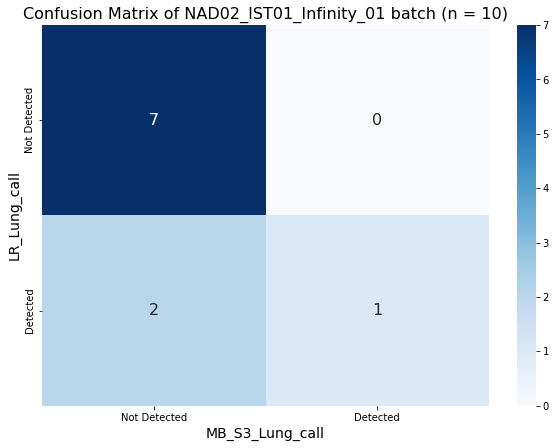

Cohen's Kappa: 0.41


In [21]:
#For batch NAD02_IST01_Infinity_01

from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
df_NAD_MRD_plot['LR_lung_call_mapped'] = df_NAD_MRD_plot['LR_Lung_call'].map({"Detected": 1, "Not Detected": 0})
df_NAD_MRD_plot['MB_s3_lung_call_mapped'] = df_NAD_MRD_plot['MB_Lung_call'].map({"Detected": 1, "Not Detected": 0})

# Extracting the values for confusion matrix calculation
y_true = df_NAD_MRD_plot['LR_lung_call_mapped'].values
y_pred = df_NAD_MRD_plot['MB_s3_lung_call_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"], annot_kws={"size": 16})
plt.xlabel('MB_S3_Lung_call', fontsize=14)
plt.ylabel('LR_Lung_call', fontsize=14)
plt.title('Confusion Matrix of NAD02_IST01_Infinity_01 batch (n = 10)', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")

# Plot the binary caller scores for all the batch 01 and batch 02

In [38]:
# pull the LR_lung_score

def pull_LR_score(df):
    for index, row in df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
        msre_lr_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
        msre_df = pd.read_table(msre_lr_file)

        LR_Lung_score = msre_df.loc[msre_df['model_name'] == 'LUNG', 'methyl_score'].iloc[0]
        df.at[index, "LR_Lung_score"] = LR_Lung_score

    return df


# Load batch with all columns
df_NAD_MRD_all_01 = pd.read_csv(f"{work_dir}/20230918_NAD02_IST01_Infinity_01_pre_tb_tb_changed_all_cols_MRD.csv", header = 0) 
df_NAD_MRD_all_02 = pd.read_csv(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/NAD02_IST01_Infinity_02_MRD_MBs3Lung_call_replacement_MRD_0510024/NAD02_IST01_Infinity_02_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

# Pull score
df_NAD_MRD_all_new_01 = pull_LR_score(df_NAD_MRD_all_01)
df_NAD_MRD_all_new_02 = pull_LR_score(df_NAD_MRD_all_02)

# Drop duplicates
df_NAD_MRD_all_new_01 = df_NAD_MRD_all_new_01.drop_duplicates(subset = "GHSampleID")
df_NAD_MRD_all_new_02 = df_NAD_MRD_all_new_02.drop_duplicates(subset = "GHSampleID")

print(df_NAD_MRD_all_new_02.shape)
print(df_NAD_MRD_all_new_01.shape)


(51, 59)
(10, 59)


In [43]:
# For batch 01

# Load df with Lung MB score
df_NAD_MRD_3_score_01 = pd.read_csv(f"{work_dir}/df_NAD_MRD_3.csv", header = 0)
df_NAD_MRD_3_score_01 = df_NAD_MRD_3_score_01.drop_duplicates(subset = "GHSampleID")

# Load final csv
df_NAD_MRD_final_ori_01 = pd.read_csv(f"{work_dir}/NAD02_IST01_Infinity_01_MB_s3_Lung_tfv2beta_MRD_final.csv", header = 0)
print(df_NAD_MRD_final_ori_01.shape)

# Merge
df_NAD_MRD_final_new_01 = df_NAD_MRD_final_ori_01.merge(df_NAD_MRD_3_score_01[["MB_Lung_score", "GHSampleID"]], on = "GHSampleID", how = "inner")
df_NAD_MRD_final_new_01 = df_NAD_MRD_final_new_01.merge(df_NAD_MRD_all_new_01[["LR_Lung_score", "GHSampleID"]], on = "GHSampleID", how = "inner")

# Bring up the MB_Lung_score to 0
df_NAD_MRD_final_new_01["MB_Lung_score"] = df_NAD_MRD_final_new_01["MB_Lung_score"] + 20.34395472179529
print(df_NAD_MRD_final_new_01.shape)
df_NAD_MRD_final_new_01.head()

# Save the data
df_NAD_MRD_final_new_01.to_csv(f"{work_dir}/NAD02_IST01_Infinity_01_MB_s3_Lung_tfv2beta_MRD_final_withLungScore.csv", index = False)


(11, 35)
(11, 37)


In [44]:
# For batch 02

# Load df with Lung MB score
df_NAD_MRD_3_score_02 = pd.read_csv(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/NAD02_IST01_Infinity_02_MRD_MBs3Lung_call_replacement_MRD_0510024/df_NAD_MRD_3.csv", header = 0)
df_NAD_MRD_3_score_02 = df_NAD_MRD_3_score_02.drop_duplicates(subset = "GHSampleID")

# Load final csv
df_NAD_MRD_final_ori_02 = pd.read_csv(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/NAD02_IST01_Infinity_02_MRD_MBs3Lung_call_replacement_MRD_0510024/NAD02_IST01_Infinity_02_MB_s3_Lung_tfv2beta_MRD_final.csv", header = 0)
print(df_NAD_MRD_final_ori_02.shape)

# Merge
df_NAD_MRD_final_new_02 = df_NAD_MRD_final_ori_02.merge(df_NAD_MRD_3_score_02[["MB_Lung_score", "GHSampleID"]], on = "GHSampleID", how = "inner")
df_NAD_MRD_final_new_02 = df_NAD_MRD_final_new_02.merge(df_NAD_MRD_all_new_02[["LR_Lung_score", "GHSampleID"]], on = "GHSampleID", how = "inner")

# Bring up the MB_Lung_score to 0
df_NAD_MRD_final_new_02["MB_Lung_score"] = df_NAD_MRD_final_new_02["MB_Lung_score"] + 20.34395472179529
print(df_NAD_MRD_final_new_02.shape)
df_NAD_MRD_final_new_02.head()

# Save the data
df_NAD_MRD_final_new_02.to_csv(f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/NAD02_IST01_Infinity_02_MRD_MBs3Lung_call_replacement_MRD_0510024/NAD02_IST01_Infinity_02_MB_s3_Lung_tfv2beta_MRD_final_withLungScore.csv", index = False)

(54, 35)
(54, 37)


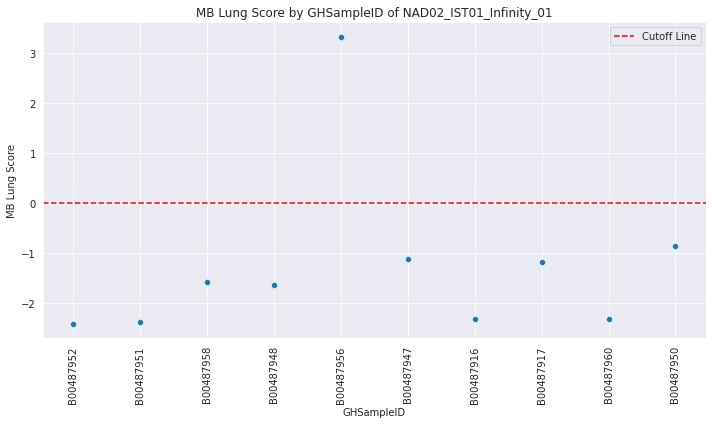

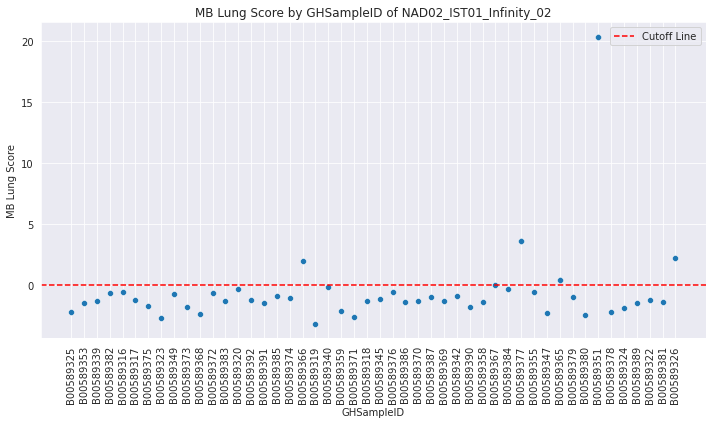

In [53]:
# Plot the Lung score distribution

def lung_socre_distribution(input, title_suffix):
    # Filter for Success samples only
    input = input[input["Sample_status"] == 'SUCCESS'] 
    # Creating the plot
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
    sns.scatterplot(x='GHSampleID', y='MB_Lung_score', data=input)

    # Adding a horizontal line at the cutoff
    plt.axhline(y=0, color='r', linestyle='--', label='Cutoff Line')

    # Adding labels and title
    plt.xlabel('GHSampleID')
    plt.ylabel('MB Lung Score')
    plt.title(f'MB Lung Score by GHSampleID of {title_suffix}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.legend()  # Show legend

    # Display the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


# Creating the plot
lung_socre_distribution(df_NAD_MRD_final_new_01, "NAD02_IST01_Infinity_01")
lung_socre_distribution(df_NAD_MRD_final_new_02, "NAD02_IST01_Infinity_02")

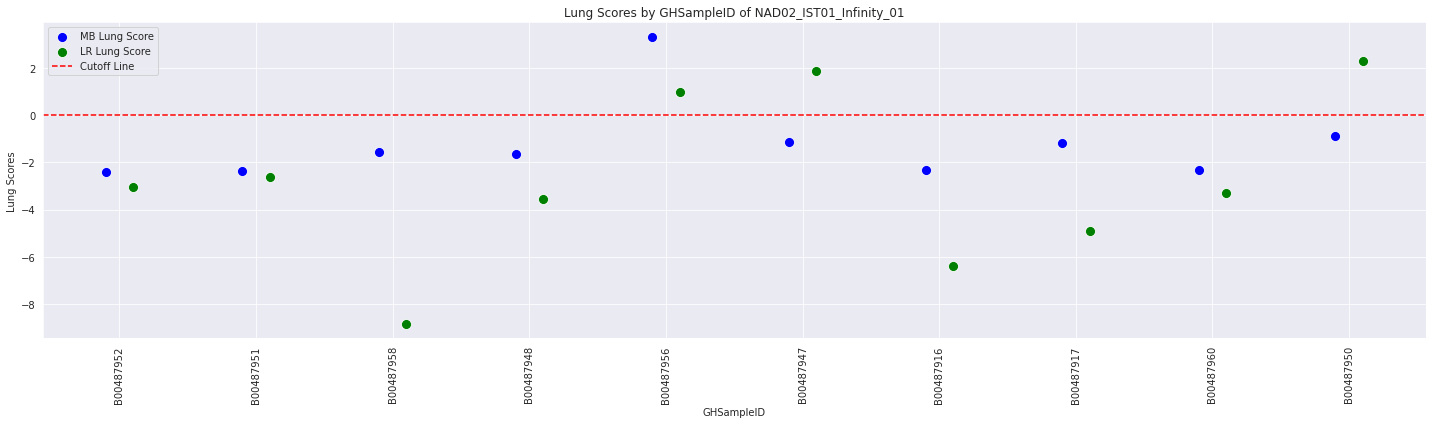

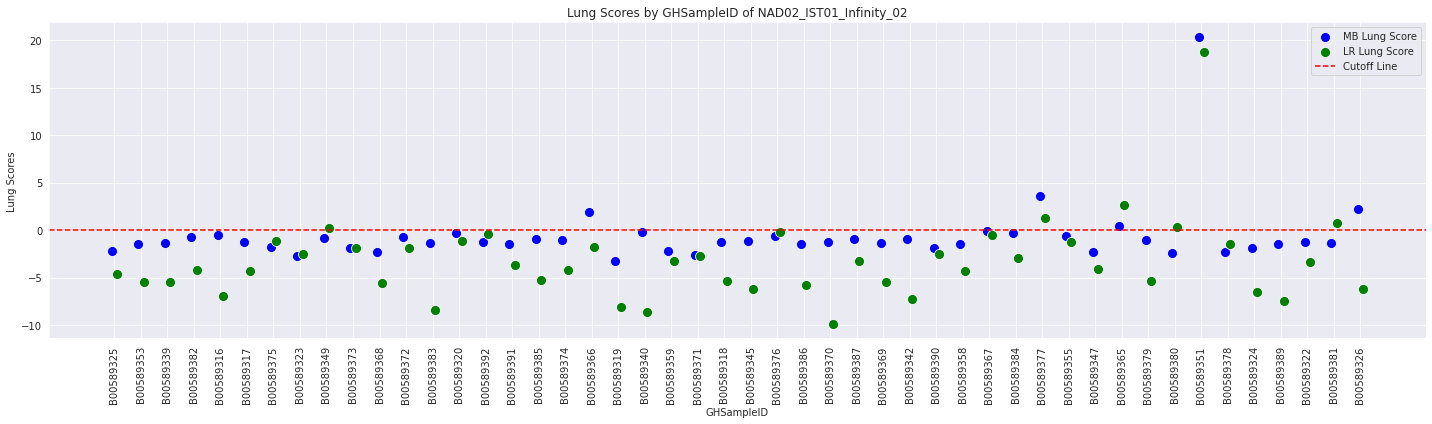

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def lung_score_distribution(input, title_suffix):
    # Filter for Success samples only and drop duplicates
    input = input[input["Sample_status"] == 'SUCCESS']
    input = input.drop_duplicates(subset = "GHSampleID")

    # Creating the plot
    sns.set_style('darkgrid')
    plt.figure(figsize=(20, 6))  # Adjust the figure size as necessary

    # Calculate positions for each set of points
    positions = np.arange(len(input))
    width = 0.2  # the width of the bars

    # Plotting MB_Lung_score
    sns.scatterplot(x=positions - width/2, y='MB_Lung_score', data=input, color='blue', label='MB Lung Score', s=100)

    # Plotting LR_Lung_score
    sns.scatterplot(x=positions + width/2, y='LR_Lung_score', data=input, color='green', label='LR Lung Score', s=100)

    # Adding a horizontal line at the cutoff
    plt.axhline(y=0, color='r', linestyle='--', label='Cutoff Line')

    # Adding labels and title
    plt.xticks(positions, input['GHSampleID'], rotation=90)  # Set x-ticks to be the GHSampleIDs
    plt.xlabel('GHSampleID')
    plt.ylabel('Lung Scores')
    plt.title(f'Lung Scores by GHSampleID of {title_suffix}')
    plt.legend()  # Show legend

    # Display the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage
lung_score_distribution(df_NAD_MRD_final_new_01, "NAD02_IST01_Infinity_01")
lung_score_distribution(df_NAD_MRD_final_new_02, "NAD02_IST01_Infinity_02")


In [56]:
df_NAD_MRD_final_new_01.

(11, 37)

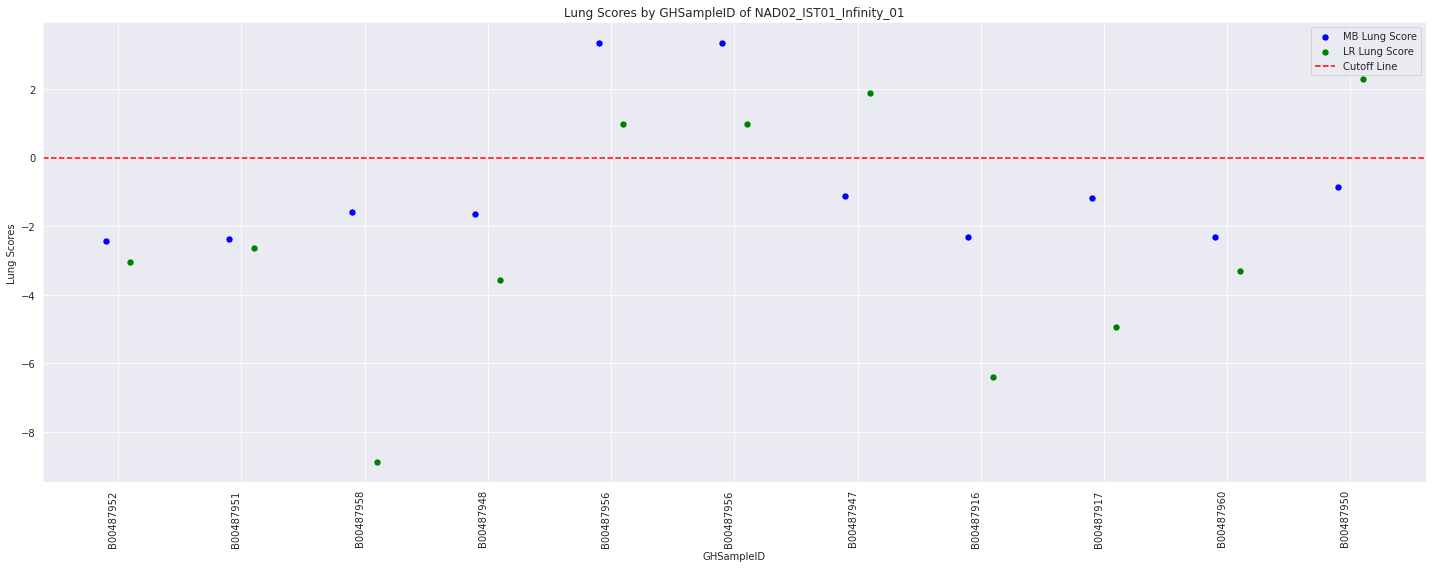

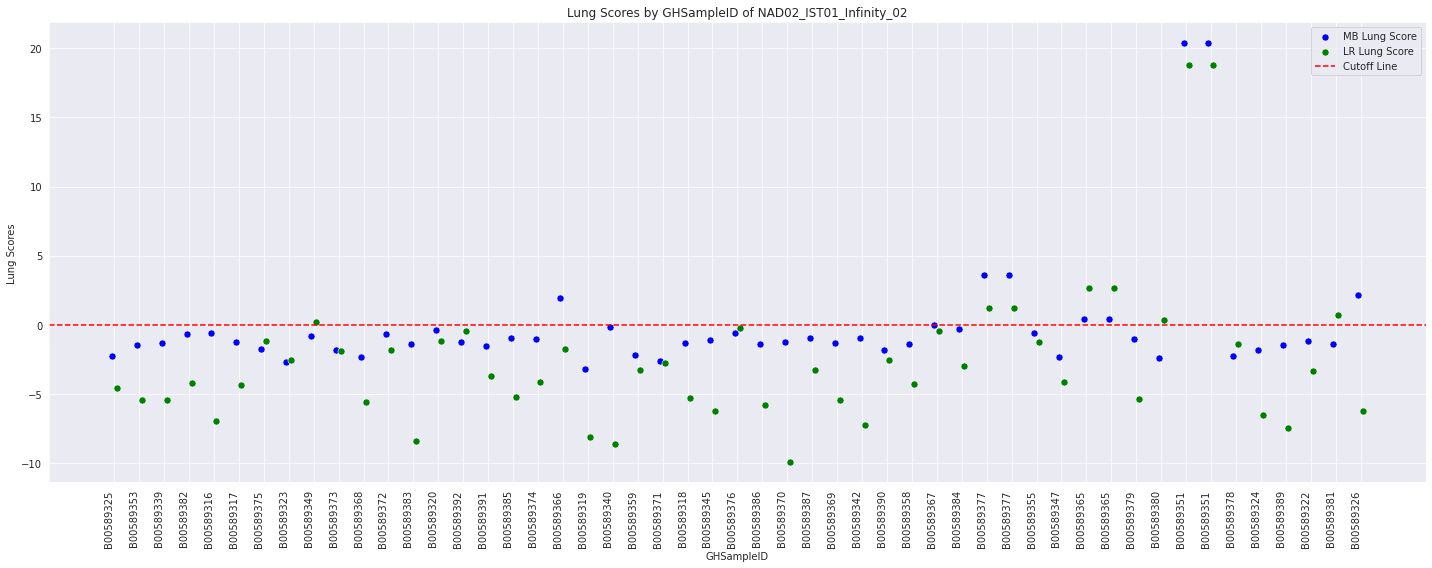

In [64]:
def lung_score_distribution(input, title_suffix):
    # Filter for Success samples only
    input = input[input["Sample_status"] == 'SUCCESS']

    # Creating the plot
    sns.set_style('darkgrid')
    plt.figure(figsize=(20, 8))  # Increase figure size for better readability

    # Calculate positions for each set of points
    positions = np.arange(len(input))
    width = 0.2  # the width of the bars

    # Plotting MB_Lung_score
    sns.scatterplot(x=positions - width/2, y='MB_Lung_score', data=input, color='blue', label='MB Lung Score', s=50)

    # Plotting LR_Lung_score
    sns.scatterplot(x=positions + width/2, y='LR_Lung_score', data=input, color='green', label='LR Lung Score', s=50)

    # Adding a horizontal line at the cutoff
    plt.axhline(y=0, color='r', linestyle='--', label='Cutoff Line')

    # Adding labels and title
    plt.xticks(positions, input['GHSampleID'], rotation=90, ha='right')  # Rotate x-ticks for better readability
    plt.xlabel('GHSampleID')
    plt.ylabel('Lung Scores')
    plt.title(f'Lung Scores by GHSampleID of {title_suffix}')
    plt.legend()  # Show legend

    # Display the plot
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Example usage
lung_score_distribution(df_NAD_MRD_final_new_01, "NAD02_IST01_Infinity_01")
lung_score_distribution(df_NAD_MRD_final_new_02, "NAD02_IST01_Infinity_02")
